### Feature Engineering and Data Transformation
#### Fraud_Data.csv and Creditcard.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import os

## ------------------ PART A — FRAUD DATASET ------------------ ##

### Load fraud data

In [2]:
fraud_path = "../data/processed/fraud_cleaned.csv"
fraud_df = pd.read_csv(fraud_path)

fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])

### Feature Engineering (Fraud)

In [3]:
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds() / 3600
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek


### Separate Features & Target

In [4]:
X_fraud = fraud_df.drop(columns=[
    'class', 'user_id', 'device_id', 'signup_time', 'purchase_time', 'ip_address', 'ip_int'
])
y_fraud = fraud_df['class']

### Train/Test Split

In [5]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(
    X_fraud, y_fraud, test_size=0.3, random_state=42, stratify=y_fraud
)

### Scale Numerical Features

In [6]:
numerical_features_fraud = ['purchase_value', 'age', 'time_since_signup', 'hour_of_day', 'day_of_week']
scaler_fraud = StandardScaler()
Xf_train_num = scaler_fraud.fit_transform(Xf_train[numerical_features_fraud])
Xf_test_num = scaler_fraud.transform(Xf_test[numerical_features_fraud])


### Encode Categorical Features

In [7]:
categorical_features_fraud = ['source', 'browser', 'sex', 'country']
ohe_fraud = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
Xf_train_cat = ohe_fraud.fit_transform(Xf_train[categorical_features_fraud])
Xf_test_cat = ohe_fraud.transform(Xf_test[categorical_features_fraud])


### Combine Features

In [8]:
Xf_train_final = np.hstack([Xf_train_num, Xf_train_cat])
Xf_test_final = np.hstack([Xf_test_num, Xf_test_cat])

### Apply SMOTE for Class Imbalance

In [9]:
smote_fraud = SMOTE(random_state=42)
Xf_train_resampled, yf_train_resampled = smote_fraud.fit_resample(Xf_train_final, yf_train)

print("Fraud dataset class distribution (after SMOTE):")
print(np.bincount(yf_train_resampled.astype(int)))

Fraud dataset class distribution (after SMOTE):
[95872 95872]


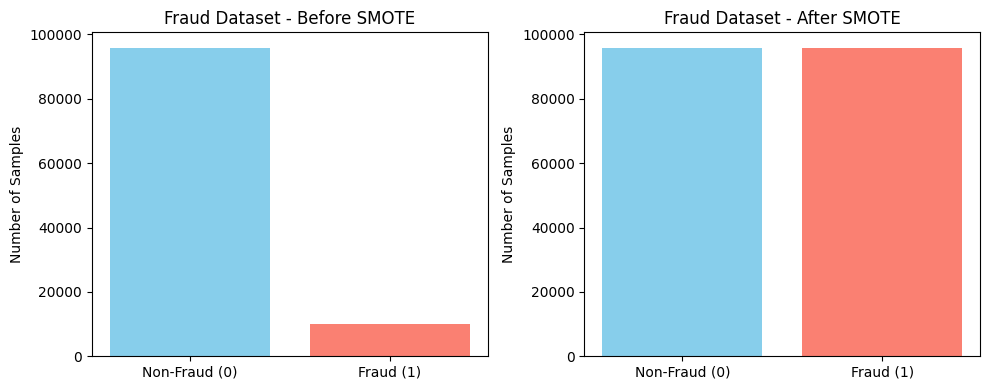

In [10]:
import matplotlib.pyplot as plt

# ----------------- FRAUD DATASET ----------------- #
# Original class distribution
fraud_class_orig = np.bincount(yf_train.astype(int))
fraud_class_resampled = np.bincount(yf_train_resampled.astype(int))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(['Non-Fraud (0)','Fraud (1)'], fraud_class_orig, color=['skyblue','salmon'])
plt.title("Fraud Dataset - Before SMOTE")
plt.ylabel("Number of Samples")

plt.subplot(1,2,2)
plt.bar(['Non-Fraud (0)','Fraud (1)'], fraud_class_resampled, color=['skyblue','salmon'])
plt.title("Fraud Dataset - After SMOTE")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

### Save Fraud Feature-Engineered Data

In [11]:
processed_dir = "../data/processed"
os.makedirs(processed_dir, exist_ok=True)

fraud_train_df = pd.DataFrame(Xf_train_resampled)
fraud_train_df['class'] = yf_train_resampled
fraud_test_df = pd.DataFrame(Xf_test_final)
fraud_test_df['class'] = yf_test.values

fraud_train_df.to_csv(os.path.join(processed_dir, "fraud_train_fe.csv"), index=False)
fraud_test_df.to_csv(os.path.join(processed_dir, "fraud_test_fe.csv"), index=False)

## ------------------ PART B — CREDIT CARD DATASET ------------------ ##

### Load credit card data

In [12]:
cc_path = "../data/processed/creditcard_cleaned.csv"
cc_df = pd.read_csv(cc_path)

### Feature Engineering

In [13]:
cc_df['hour'] = (cc_df['Time'] / 3600) % 24

### Separate Features & Target

In [14]:
X_cc = cc_df.drop(columns=['Class'])
y_cc = cc_df['Class']

### Train/Test Split

In [15]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cc, y_cc, test_size=0.3, random_state=42, stratify=y_cc
)

### Scale Features

In [16]:
scaler_cc = StandardScaler()
Xc_train_scaled = scaler_cc.fit_transform(Xc_train)
Xc_test_scaled = scaler_cc.transform(Xc_test)

### Apply SMOTE

In [17]:
smote_cc = SMOTE(random_state=42)
Xc_train_resampled, yc_train_resampled = smote_cc.fit_resample(Xc_train_scaled, yc_train)

print("Credit card dataset class distribution (after SMOTE):")
print(np.bincount(yc_train_resampled.astype(int)))


Credit card dataset class distribution (after SMOTE):
[198277 198277]


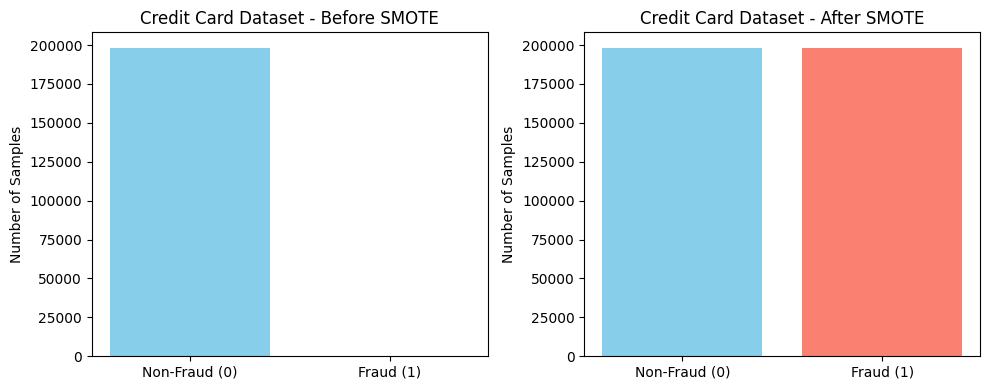

In [18]:
# ----------------- CREDIT CARD DATASET ----------------- #
cc_class_orig = np.bincount(yc_train.astype(int))
cc_class_resampled = np.bincount(yc_train_resampled.astype(int))

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar(['Non-Fraud (0)','Fraud (1)'], cc_class_orig, color=['skyblue','salmon'])
plt.title("Credit Card Dataset - Before SMOTE")
plt.ylabel("Number of Samples")

plt.subplot(1,2,2)
plt.bar(['Non-Fraud (0)','Fraud (1)'], cc_class_resampled, color=['skyblue','salmon'])
plt.title("Credit Card Dataset - After SMOTE")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

### Save Credit Card Feature-Engineered Data

In [19]:
cc_train_fe = pd.DataFrame(Xc_train_resampled, columns=Xc_train.columns)
cc_train_fe['Class'] = yc_train_resampled

cc_test_fe = pd.DataFrame(Xc_test_scaled, columns=Xc_test.columns)
cc_test_fe['Class'] = yc_test.values

cc_train_fe.to_csv(os.path.join(processed_dir, "creditcard_train_fe.csv"), index=False)
cc_test_fe.to_csv(os.path.join(processed_dir, "creditcard_test_fe.csv"), index=False)